## README
Dataset can be found [here](https://zindi.africa/competitions/spot-the-mask/data)

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torchvision.transforms import transforms
from torchvision.io import read_image, ImageReadMode

import os
import random
import math
from datetime import datetime
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [188]:
## funciton to calculate width and height of convolution layer
def conv_out_dim(shape_in, padding=[0,0], dialation=[1,1], kernel_size=[2,2], stride=[1,1]):
#     dim = 0
    dimensions = []
    for dim in range(2):
        dimension = (shape_in[dim]+2*padding[dim]-dialation[dim]*(kernel_size[dim]-1)-1)/stride[dim] + 1
        dimensions.append(math.floor(dimension))
    return np.array(dimensions)


def create_train_test_labels_csv(labels_path, train_labels_path="train_labels.csv", test_labels_path="test_labels.csv", test_size=0.3, random_state=None, stratify=None):
    labels_df = pd.read_csv(labels_path)

    ## checking if stratify needed
    if stratify:
        train, test = train_test_split(labels_df, shuffle=True, stratify=labels_df[stratify], random_state=random_state)
    else:
        train, test = train_test_split(labels_df, shuffle=True, random_state=random_state)

    ## saving data
    train.to_csv(train_labels_path, index=False)
    test.to_csv(test_labels_path, index=False)

In [189]:
## creating training and testing labels
train_labels_path="data/train_labels.csv"
test_labels_path="data/test_labels.csv"
test_size = 0.3
random_state = 42
stratify="target"

create_train_test_labels_csv("data/labels.csv",
                             train_labels_path=train_labels_path,
                             test_labels_path=test_labels_path,
                             test_size=test_size,
                             stratify=stratify,
                             random_state=random_state
                            )

In [190]:
# tr = pd.read_csv(train_labels_path)
# tr.iloc[0]

In [191]:
# te = pd.read_csv(test_labels_path)
# te.iloc[0]

In [192]:
# tr.shape[0] + te.shape[0]

In [193]:
# tr["target"].value_counts(normalize=True)

In [194]:
# te["target"].value_counts(normalize=True)

In [195]:
class MaskedFaces(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = read_image(img_path, mode=ImageReadMode.GRAY)
        ## discarding the alpha channels
        label = self.img_labels.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [196]:
# ## preparing to load the images
# annotations_file = "./data/labels.csv"
# img_dir = "./data/images"
# transform = transforms.Compose([transforms.Resize((100,100), antialias=True), transforms.ConvertImageDtype(torch.float32)])
# target_transform = lambda x: torch.tensor(x).type(torch.float32)
# dataset = MaskedFaces(annotations_file, img_dir, transform=transform, target_transform=target_transform)

img_dir = "./data/images"
target_transform = lambda x: torch.tensor(x).type(torch.float32)

## getting train dataset
annotations_file = train_labels_path
train_transform = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.Resize((100,100), antialias=True),
    transforms.ConvertImageDtype(torch.float32)])
train_dataset = MaskedFaces(annotations_file, img_dir, transform=train_transform, target_transform=target_transform)

## getting test dataset
annotations_file = test_labels_path
test_transform = transforms.Compose([transforms.Resize((100,100), antialias=True), transforms.ConvertImageDtype(torch.float32)])
test_dataset = MaskedFaces(annotations_file, img_dir, transform=test_transform, target_transform=target_transform)

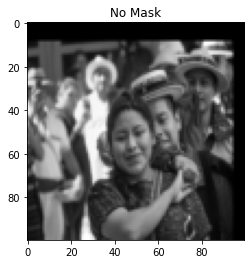

In [197]:
idx = np.random.randint(len(train_dataset)+1)
img = train_dataset[idx][0]
label = train_dataset[idx][1]
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.title("Has Mask" if label else "No Mask")
plt.show()

In [198]:
# splitting data into train and test
# generator = torch.Generator().manual_seed(42)
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7,0.3], generator=generator)

In [199]:
## creating model
# class CNN(nn.Module):
#     def __init__(self, K):
#         super(CNN, self).__init__()

#         ## creating convolutional layers
#         self.conv = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=2),
#                                   nn.ReLU(),
#                                   nn.BatchNorm2d(32),
#                                   nn.Conv2d(32, 64, kernel_size=3, stride=2),
#                                   nn.ReLU(),
#                                   nn.BatchNorm2d(64),
#                                   nn.Conv2d(64, 128, kernel_size=3, stride=2),
#                                   nn.ReLU(),
#                                   nn.BatchNorm2d(128),
#                                   nn.Conv2d(128, 256, kernel_size=3, stride=2),
#                                   nn.ReLU(),
#                                   nn.BatchNorm2d(256)
#                                  )

#         self.dense = nn.Sequential(
#             nn.Dropout(p=0.5),
#             nn.Linear(5*5*256, 512),
#             nn.ReLU(),
#             nn.Dropout(p=0.2),
#             nn.Linear(512, K),
#             nn.Sigmoid()
#             )

#     def forward(self, X):
#         X = self.conv(X)
#         X = X.view(X.shape[0], -1)
#         X = self.dense(X)
#         return X

## TRYING OUT THE `VGG` ARCHITECTURE
class CNN(nn.Module):
    def __init__(self,K):
        super(CNN, self).__init__()

        ## using the same concept from VGG here
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32),
                                   nn.Conv2d(32, 32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32),
                                   nn.MaxPool2d(2),
                                  )
        
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.MaxPool2d(2),
                                  )
        
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(128),
                                   nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(128),
                                   nn.MaxPool2d(2),
                                  )
    
        self.fc1 = nn.Linear(128*12*12,1024)
        self.fc2 = nn.Linear(1024, K)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = X.view(X.size(0), -1)
        X = F.dropout(X, p=0.5)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.2)
        X = self.fc2(X)
        X = F.sigmoid(X)

        return X

In [200]:
## preparting tools for training
model = CNN(1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [201]:
## determining size of data after convolution
# dim = conv_out_dim((100,100), padding=[0,0], dialation=[1,1], kernel_size=[3,3], stride=[2,2])
# dim = conv_out_dim(dim,kernel_size=[3,3], stride=[2,2])
# dim = conv_out_dim(dim,kernel_size=[3,3], stride=[2,2])
# # dim = conv_out_dim(dim,kernel_size=[3,3], stride=[2,2])
# dim
dim = conv_out_dim((100,100), padding=[1,1], dialation=[1,1], kernel_size=[3,3], stride=[1,1])
dim = conv_out_dim(dim,kernel_size=[3,3], stride=[1,1], dialation=[1,1], padding=[1,1])
# dim = dim /2
# dim = conv_out_dim(dim, padding=[1,1], dialation=[1,1], kernel_size=[3,3], stride=[1,1])
# dim = conv_out_dim(dim,kernel_size=[3,3], stride=[1,1])
# dim = dim/2
# dim = conv_out_dim(dim, padding=[1,1], dialation=[1,1], kernel_size=[3,3], stride=[1,1])
# dim = conv_out_dim(dim,kernel_size=[3,3], stride=[1,1])
# dim = dim/2
dim

array([100, 100])

In [202]:
## creating dataloaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True
                                          )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                           shuffle=False
                                          )

In [203]:
# dt = test_dataset
# tmp = torch.utils.data.DataLoader(dt,
#                                            batch_size=len(dt),
#                                            shuffle=True
#                                           )
# _,t = next(iter(tmp))

In [204]:
# t.unique(return_counts=True)[1]/len(dt)

In [205]:
## creating training function
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs):
    info = {"train_losses": [], "test_losses":[]}
    for it in range(epochs):
        time_start = datetime.now()
        ## training
        model.train()
        epoch_losses = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1,1))
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        ## adding mean of loss to train losses
        info["train_losses"].append(np.mean(epoch_losses))

        ## resetting epoch losses
        epoch_losses = []

        ## testing
        model.eval()
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1,1))
            epoch_losses.append(loss.item())

        ## adding mean of loss to test losses
        info["test_losses"].append(np.mean(epoch_losses))

        ## getting duration of epochs
        dt = datetime.now() - time_start
        ## printing after epoch
        print(f"Train Loss {info['train_losses'][-1]}, Test Loss {info['test_losses'][-1]}, Duration {dt}")
                                   
    return info

In [206]:
## training model
train_info = train_model(model, criterion, optimizer, train_loader, test_loader, 30)

Train Loss 0.7602474838495255, Test Loss 0.7575919230779012, Duration 0:01:57.070830
Train Loss 0.716391310095787, Test Loss 0.7559575935204824, Duration 0:02:01.840478
Train Loss 0.6538566574454308, Test Loss 0.7251532872517904, Duration 0:02:01.827001
Train Loss 0.6290749739855528, Test Loss 0.6299701631069183, Duration 0:02:24.339809
Train Loss 0.6298907026648521, Test Loss 0.5825571666161219, Duration 0:02:30.323527
Train Loss 0.5909607540816069, Test Loss 0.5659228960673014, Duration 0:02:27.790224
Train Loss 0.5847938153892756, Test Loss 0.543219193816185, Duration 0:02:34.983005
Train Loss 0.593853522092104, Test Loss 0.5960019032160441, Duration 0:02:32.060899
Train Loss 0.5809352304786444, Test Loss 0.5402173846960068, Duration 0:02:29.591497
Train Loss 0.5492715276777744, Test Loss 0.5693912357091904, Duration 0:02:35.113378
Train Loss 0.5592944659292698, Test Loss 0.5540621330340704, Duration 0:03:38.704381
Train Loss 0.5537645425647497, Test Loss 0.5720483859380087, Duratio

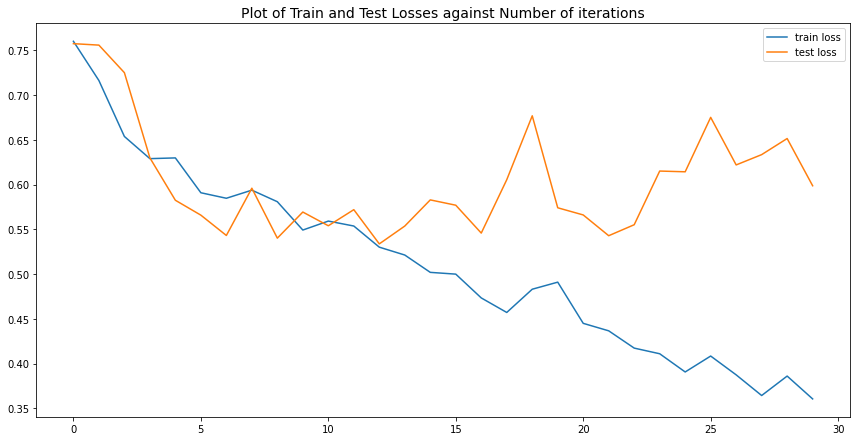

In [207]:
fig = plt.figure(figsize=(12,6))
plt.plot(train_info["train_losses"], label="train loss")
plt.plot(train_info["test_losses"], label="test loss")
plt.tight_layout()
plt.title("Plot of Train and Test Losses against Number of iterations", fontdict={"size":14})
plt.legend()
plt.show()

In [208]:
## getting accuracies
test_acc = 0
train_acc = 0

with torch.no_grad():
    model.eval()
    
    num_correct = 0
    total = 0
    for inputs, targets in train_loader:
        preds = model(inputs)
        num_correct += (np.round(preds.numpy().flatten()) == targets.numpy().flatten()).sum()
        total += len(targets)
    
    train_acc = num_correct/total
    
    num_correct = 0
    total = 0
    for inputs, targets in test_loader:
        preds = model(inputs)
        num_correct += (np.round(preds.numpy().flatten()) == targets.numpy().flatten()).sum()
        total += len(targets)
    
    test_acc = num_correct/total
    
print(f"Train accuracy: {train_acc}, Test Accuracy: {test_acc}")

Train accuracy: 0.8450560652395515, Test Accuracy: 0.7186544342507645


In [209]:
## getting AUC score of test data
def get_auc_score(model, dataloader):
    model.eval()
    preds = np.array([])
    pred_targets = np.array([])
    for inputs, targets in dataloader:
        preds = np.concatenate([preds, model(inputs).detach().numpy().flatten()])
        pred_targets = np.concatenate([pred_targets, targets])

    return roc_auc_score(pred_targets, preds)

In [210]:
print(f"AUC Score: {get_auc_score(model, test_loader)}")

AUC Score: 0.8045723265733742


In [211]:
## getting the prediction dataset
annotations_file = "./data/SampleSubmission.csv"
prediction_dataset = MaskedFaces(annotations_file, img_dir, transform=test_transform, target_transform=target_transform)

In [212]:
pred_data_loader = torch.utils.data.DataLoader(prediction_dataset,
                                               batch_size=len(prediction_dataset),
                                               shuffle=False
                                              )

X_preds, _ = next(iter(pred_data_loader))

model.eval()
preds = model(X_preds)

In [213]:
preds = preds.detach().numpy()

In [214]:
## saving predictions
# img_labels = pd.read_csv("data/SampleSubmission.csv").iloc[:,0]
# pd.DataFrame({"image":img_labels.values, "target":preds.flatten()}).to_csv("submission/submission9.csv", index=False)